In [1]:
import numpy as np
from skimage import io

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt

import seaborn as sns
sns.set_style("dark")

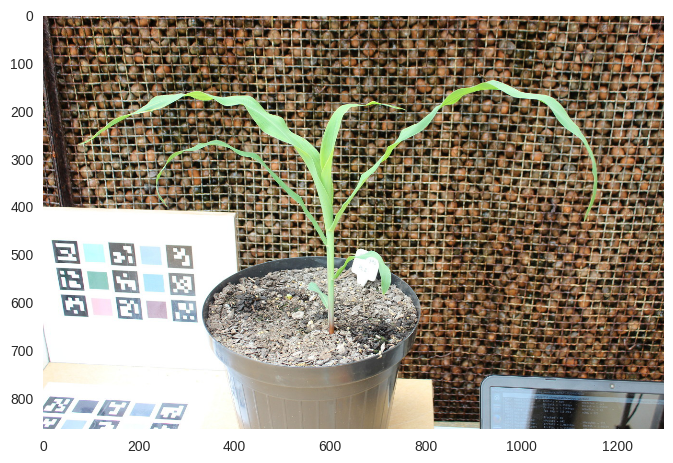

In [3]:
I = io.imread('data/maize.jpg')
plt.imshow(I)

In [4]:
traits = {}

# Segmentação da planta

In [5]:
import scipy as sp

from skimage import measure, color
from skimage import segmentation as seg
from skimage import morphology as morph

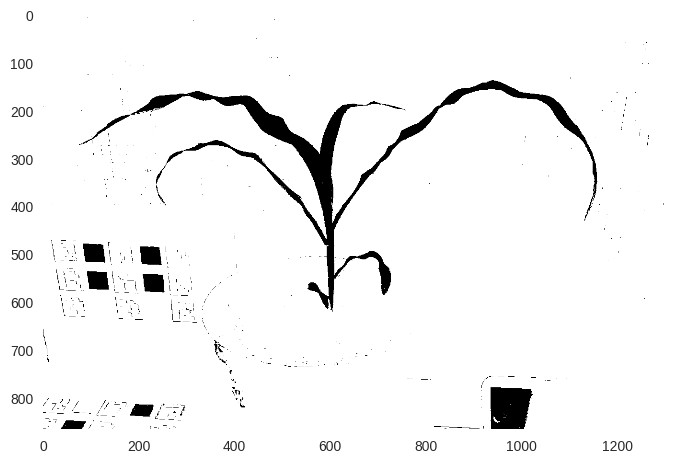

In [6]:
mask = sp.logical_and(I[:,:,1] > 1.1 * I[:,:,0], I[:,:,1] > 192)

foreground = np.zeros_like(mask, dtype=np.uint8)
foreground[mask] = 1

plt.imshow(foreground)

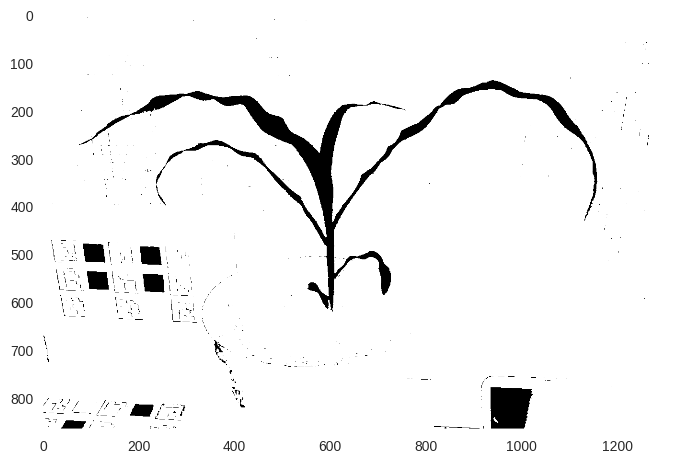

In [7]:
foreground = morph.binary_closing(foreground, morph.disk(1))

plt.imshow(foreground)

(566, ' objetos')


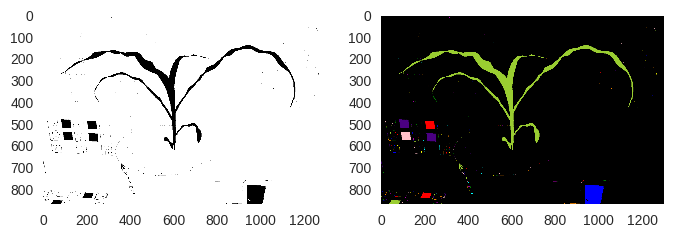

In [8]:
labels, num = measure.label(foreground, background=0, return_num=True)
print(num, ' objetos')
labels = seg.clear_border(labels)

plt.subplot(1,2,1)
plt.imshow(foreground)

plt.subplot(1,2,2)
plt.imshow(color.label2rgb(labels, bg_label=0))

In [9]:
areas = {region.label:region.area for region in measure.regionprops(labels) if region.area > 100**2}
areas

{30: 37429}

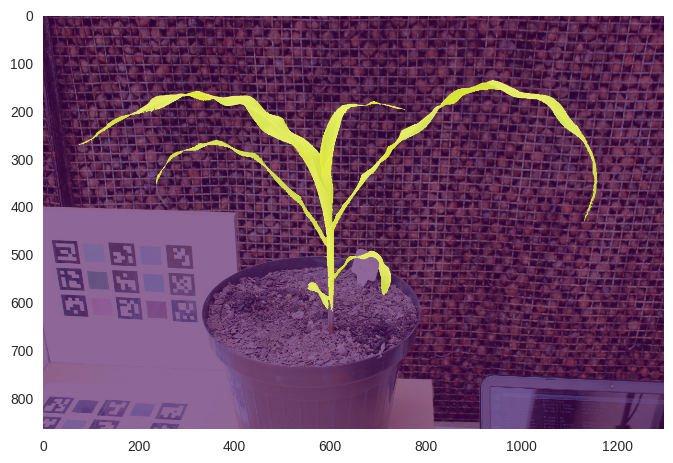

In [10]:
plant = np.zeros_like(labels, dtype=np.uint8)
plant[labels == 30] = 1

plt.imshow(plant, cmap=plt.cm.viridis)
plt.imshow(I, alpha=0.4)

# "Área"  (contagem de pixeis)

In [11]:
A = plant.sum()
A

37429

In [12]:
traits['area'] = A

# "Altura"

In [13]:
height, width = plant.shape
height, width

(864, 1296)

In [14]:
plant_pix = np.argwhere(plant == 1)
plant_pix

array([[136, 936],
       [136, 937],
       [136, 938],
       ..., 
       [616, 604],
       [617, 604],
       [618, 604]])

In [15]:
y_top, x_top = plant_pix[0]
y_bottom, x_bottom = plant_pix[-1]

In [16]:
x_top, y_top, x_bottom, y_bottom

(936, 136, 604, 618)

In [17]:
plant_height = y_bottom - y_top
plant_height

482

In [18]:
traits['height'] = plant_height

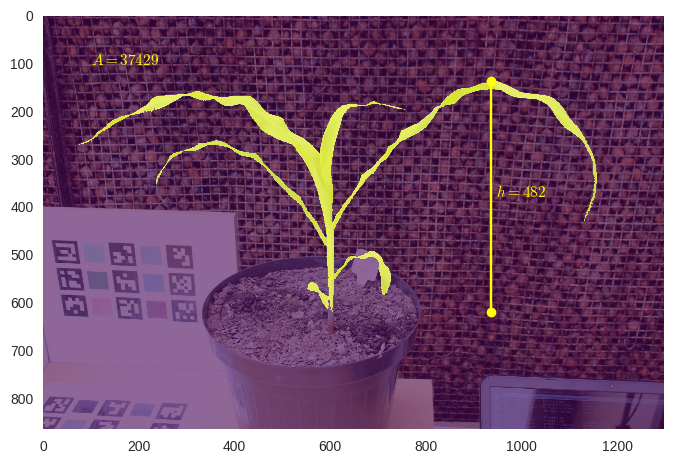

In [19]:
plt.plot([x_top, x_top], [y_top, y_bottom], color='yellow', marker='o', linestyle='solid')

font = {'family': 'serif',
        'color':  'yellow',
        'weight': 'normal',
        'size': 11,
        }
plt.text(x_top + 11, y_top + (y_bottom - y_top)/2, r'$h = %d$' % plant_height, fontdict=font)
plt.text(100, 100, r'$A = %d$' % plant.sum(), fontdict=font)

plt.imshow(plant, cmap=plt.cm.viridis, interpolation='nearest')
plt.imshow(I, alpha=0.4)           

In [20]:
pix_x_ascending = np.sort(plant_pix[:,1])
pix_x_ascending

array([  75,   76,   76, ..., 1155, 1156, 1156])

In [21]:
x_left, x_right = pix_x_ascending[0], pix_x_ascending[-1]
x_left, x_right

(75, 1156)

In [22]:
plant_width = x_right - x_left
plant_width

1081

In [23]:
traits['width'] = plant_width

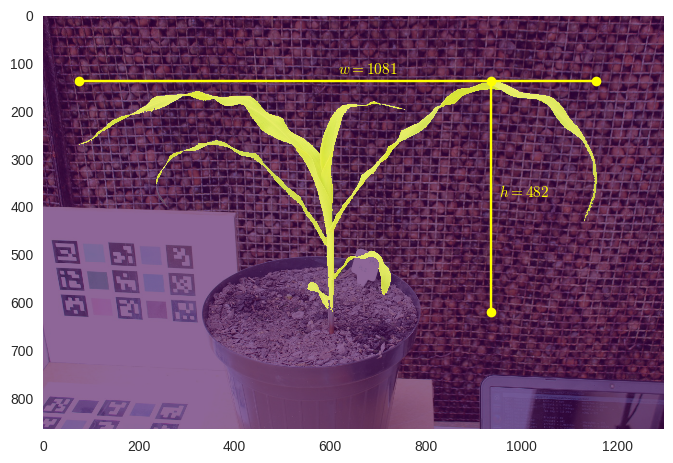

In [24]:
plt.plot([x_top, x_top], [y_top, y_bottom], color='yellow', marker='o', linestyle='solid')
plt.plot([x_left, x_right], [y_top, y_top], color='yellow', marker='o', linestyle='solid')

font = {'family': 'serif',
        'color':  'yellow',
        'weight': 'normal',
        'size': 11,
        }
plt.text(x_top + 17, y_top + plant_height/2, r'$h = %d$' % plant_height, fontdict=font)
plt.text(x_left + plant_width/2, y_top - 17, r'$w = %d$' % plant_width, fontdict=font)

plt.imshow(plant, cmap=plt.cm.viridis, interpolation='nearest')
plt.imshow(I, alpha=0.4)           

# Esqueleto 

In [25]:
from skimage import morphology as morph

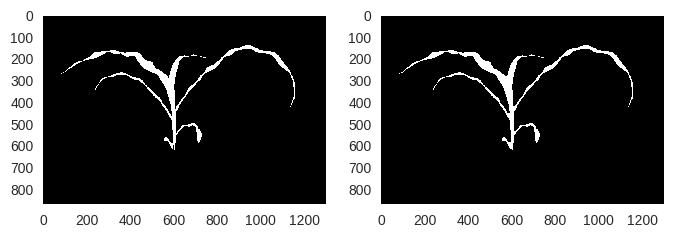

In [26]:
filled_plant = morph.binary_closing(plant, morph.disk(5))

plt.subplot(1,2,1)
plt.imshow(plant, interpolation='nearest', cmap=plt.cm.binary_r)
plt.subplot(1,2,2)
plt.imshow(filled_plant, interpolation='nearest', cmap=plt.cm.binary_r)

In [27]:
skeleton = morph.skeletonize_3d(filled_plant)

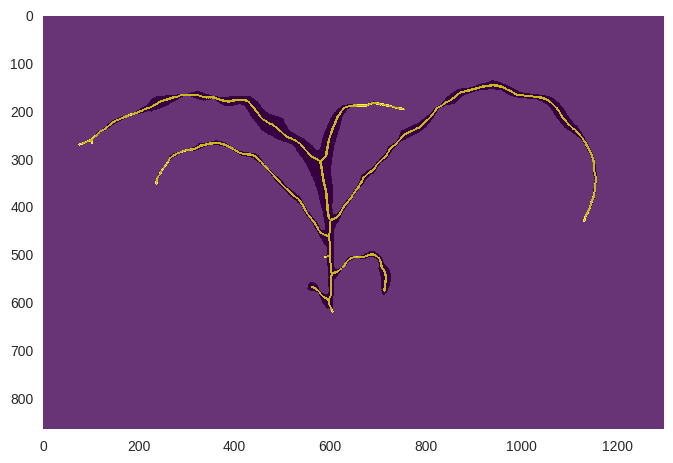

In [28]:
plt.imshow(filled_plant, interpolation='nearest', cmap=plt.cm.binary)
plt.imshow(morph.dilation(skeleton, morph.disk(2)), interpolation='nearest', cmap=plt.cm.viridis, alpha=0.8)

In [29]:
skeleton[skeleton > 0] = 1

In [30]:
def count_neighbors(I, i, j):
    return I[i-1:i+2,j-1:j+2].sum()

In [31]:
skel_points = np.argwhere(skeleton > 0)
skel_points

array([[146, 937],
       [146, 938],
       [146, 939],
       ..., 
       [616, 603],
       [617, 604],
       [618, 604]])

In [32]:
tips = []
for i, j in skel_points:
    if count_neighbors(skeleton, i, j) == 2:
        tips.append((i,j))
tips = np.array(tips)

In [33]:
tips

array([[ 197,  753],
       [ 267,  102],
       [ 270,   76],
       [ 352,  236],
       [ 429, 1129],
       [ 504,  587],
       [ 567,  561],
       [ 575,  712],
       [ 618,  604]])

In [34]:
leaf_count = tips.shape[0] - 1
leaf_count

8

In [35]:
traits['leaf count'] = leaf_count

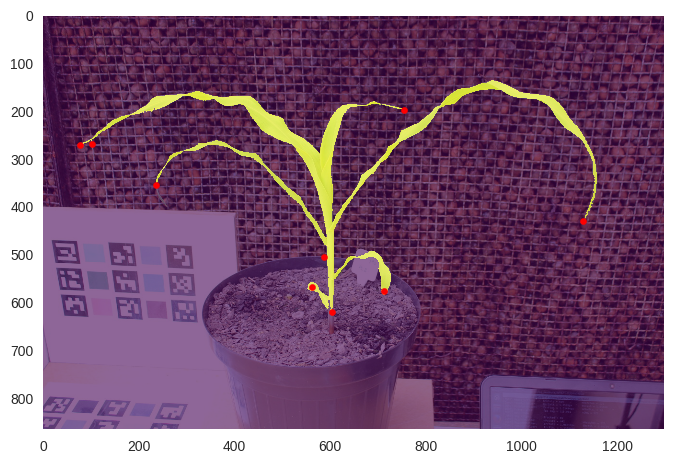

In [36]:
plt.scatter(tips[:,1], tips[:,0], color='red')
plt.imshow(plant, cmap=plt.cm.viridis, interpolation='nearest')
plt.imshow(I, alpha=0.4)

Alternativa para `side.leaf.length.sum` proposto por Chen *et al.* (2014):

In [37]:
leaf_length_sum = skeleton.sum()
leaf_length_sum

2461

In [38]:
traits['leaf length sum'] = leaf_length_sum

## Distância média ao esqueleto

In [39]:
def neighbors(i, j, width, height):
    N = [(i-1, j), (i+1, j), (i,j-1), (i,j+1)]
    return [(k, l) for k, l in N if k >= 0 and l >= 0 and k < height and l < width]

In [40]:
neighbors(0, 0, width, height)

[(1, 0), (0, 1)]

In [41]:
neighbors(5, 11, width, height)

[(4, 11), (6, 11), (5, 10), (5, 12)]

A **fila** se inicia com os pontos do esqueleto

In [42]:
queue = [(i,j) for i, j  in np.argwhere(skeleton > 0)]

In [43]:
W = -1 * np.ones((height, width), dtype=np.int32)
for i, j in queue:
    W[i,j] = 0

In [44]:
while len(queue) > 0: 
    i, j = queue.pop(0)
    for i_n, j_n in neighbors(i, j, width, height):
        if plant[i_n, j_n] == 1 and W[i_n, j_n] == -1:
            W[i_n, j_n] = W[i, j] + 1
            queue.append((i_n,j_n))


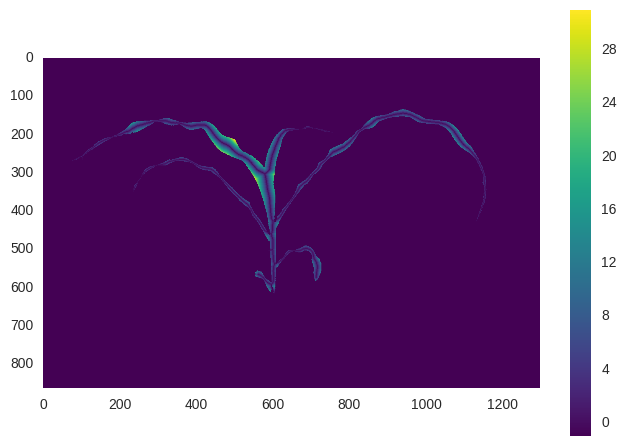

In [45]:
plt.figure()
plt.imshow(W, cmap=plt.cm.viridis)
plt.colorbar()

Note que $W$ apresenta valores negativos nos pixeis que não pertencem à planta:

In [46]:
W

array([[-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       ..., 
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1]], dtype=int32)

Somatório das distâncias ao esqueleto nos pixeis de planta: `W[W > 0].sum()`

In [47]:
leaf_width_average = W[W > 0].sum()/A
leaf_width_average

5.7633118704747659

In [48]:
traits['leaf width average'] = leaf_width_average

# Perímetro e compactação

In [49]:
perimeter = measure.perimeter(plant)
perimeter

5810.2099166972366

In [50]:
traits['border length'] = perimeter

In [51]:
compactness = perimeter**2/A
compactness

901.9353783453181

In [52]:
traits['compactness'] = compactness

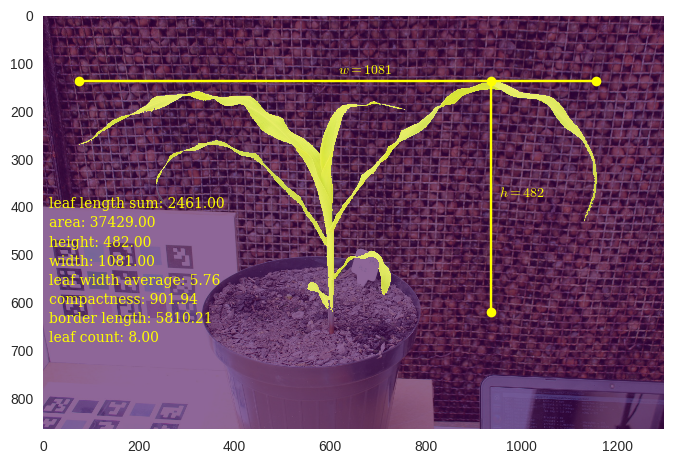

In [53]:
plt.plot([x_top, x_top], [y_top, y_bottom], color='yellow', marker='o', linestyle='solid')
plt.plot([x_left, x_right], [y_top, y_top], color='yellow', marker='o', linestyle='solid')

font = {'family': 'serif',
        'color':  'yellow',
        'weight': 'normal',
        'size': 10,
        }
plt.text(x_top + 17, y_top + plant_height/2, u'$h = %d$' % plant_height, fontdict=font)
plt.text(x_left + plant_width/2, y_top - 17, u'$w = %d$' % plant_width, fontdict=font)

text_pos = 400
for trait, value in traits.iteritems():
    plt.text(11, text_pos, u'%s: %.2f' % (trait, value), fontdict=font)
    text_pos += 40
    
plt.imshow(plant, cmap=plt.cm.viridis, interpolation='nearest')
plt.imshow(I, alpha=0.4)

# *Traits* de cor

In [54]:
I_hsv = color.rgb2hsv(I)
I_lab = color.rgb2lab(I)

In [55]:
hue = I_hsv[:,:,0]
h_average = hue[plant == 1].mean()
h_average

0.31104723848285321

In [56]:
traits['h_average'] = h_average

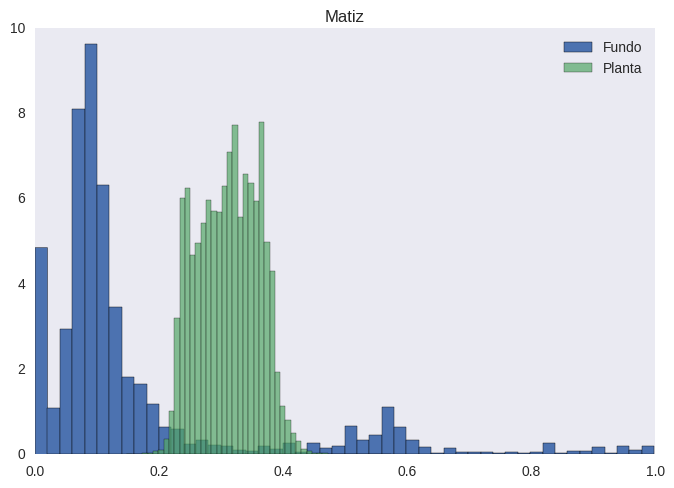

In [57]:
plt.hist(hue[plant == 0], bins=50, normed=True, label='Fundo')
plt.hist(hue[plant == 1], bins=50, normed=True, label='Planta', alpha=0.7)
plt.legend()
plt.title('Matiz')

In [58]:
b_channel = I_lab[:,:,2]
b_average = b_channel[plant == 1].mean()
b_average

28.157325341151974

In [59]:
traits['b_mean'] = b_average

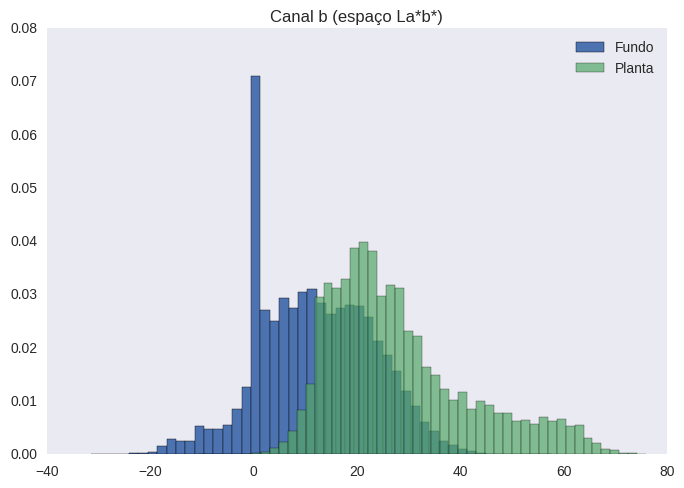

In [60]:
plt.hist(b_channel[plant == 0], bins=50, normed=True, label='Fundo')
plt.hist(b_channel[plant == 1], bins=50, normed=True, label='Planta', alpha=0.7)
plt.legend()
plt.title(u'Canal b (espaço La*b*)')